##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments

In [1]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [2]:
from tools.quantum_evolution import trotter_circuit, state_operator, measure_operator, quantum_operator_single_sxx, quantum_operator_single_sz
from tools.classical_evolution import state_probability, operator_sz, operator_sxx, expectation_value

In [3]:
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, ylim
from numpy import linspace, pi, zeros_like, zeros
from scipy.linalg import expm
from itertools import combinations

## Probability of all spins up and energy variation
---
### Classical simulation

In [23]:
# Checking if the hamiltonian is correct
spins = 3 # Number of 2-level systems
coupling = 1
frequency = 1

In [24]:
# Classical simulation of the Heisenberg dimer model
times = linspace(0, 2 * pi / frequency, 1000)

# Initial state definition
initial_state = zeros(2 ** spins, dtype = complex)
initial_state[-1] = 1

# State of all spins up
state_up = zeros(2 ** spins, dtype = complex)
state_up[0] = 1

# Hamiltonian operator
hamiltonian = frequency * operator_sz(spins) - 2 * coupling * operator_sxx(spins)

# Measures 
probabilities = zeros_like(times)
magnetization = zeros_like(times)
coupling_energy = zeros_like(times)

In [25]:
# Simulations
for i, t in enumerate(times):
    evolved_state = expm(-1j * hamiltonian * t) @ initial_state
    probabilities[i] = state_probability(evolved_state, state_up)
    
    magnetization[i] = expectation_value(evolved_state, operator_sz(spins)) / spins 
    magnetization[i] += 1 / 2
    
    coupling_energy[i] = - 2 * coupling * expectation_value(evolved_state, operator_sxx(spins))
    coupling_energy[i] /= spins * frequency

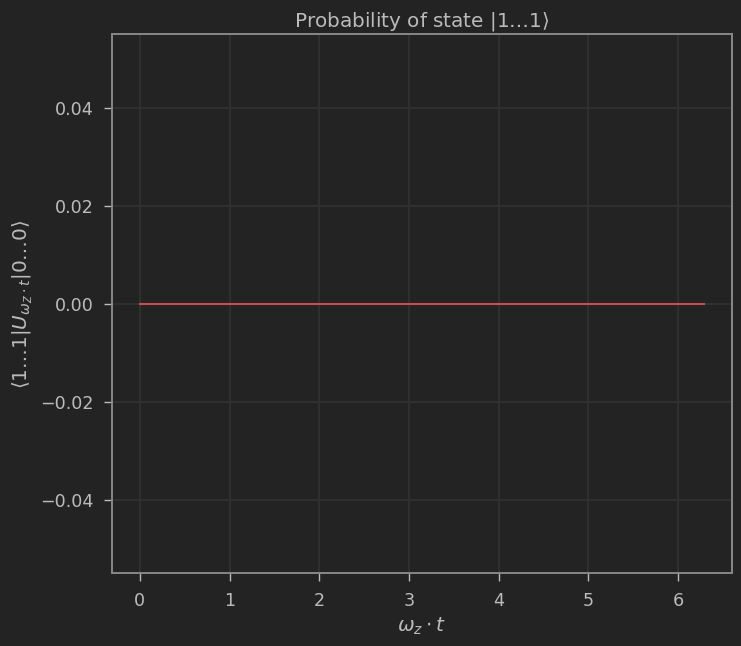

In [26]:
plot(times, probabilities, '-r')
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
show()

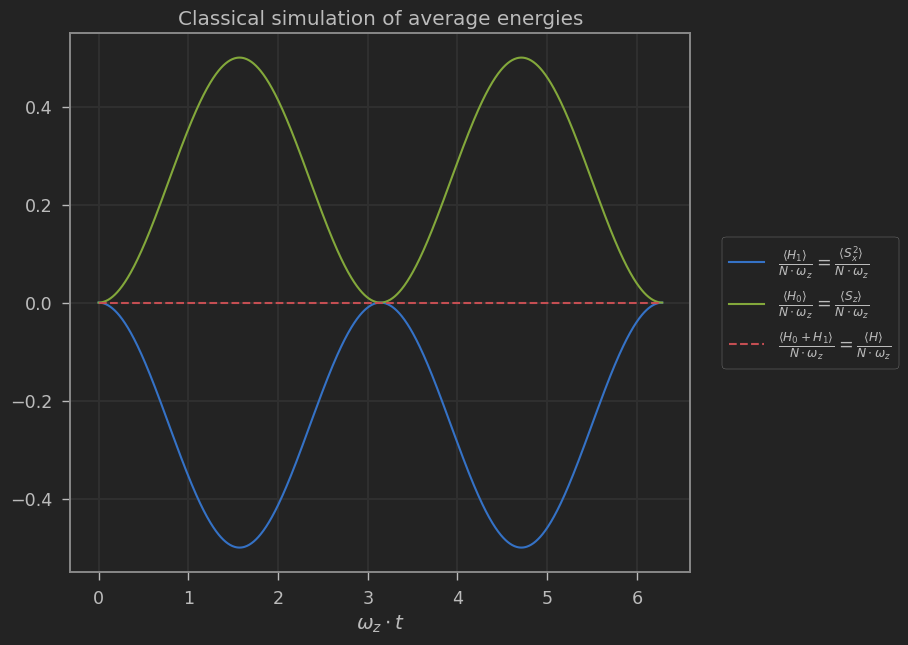

In [27]:
plot(times, coupling_energy, label = r'$\frac{\langle H_1\rangle}{N\cdot\omega_z}=\frac{\langle S_x^2\rangle}{N\cdot\omega_z} $' )    
plot(times, magnetization, label = r'$\frac{\langle H_0\rangle}{N\cdot\omega_z}=\frac{\langle S_z\rangle}{N\cdot\omega_z} $' )  
plot(times, magnetization + coupling_energy, '--', label = r'$\frac{\langle H_0 + H_1\rangle}{N\cdot\omega_z}=\frac{\langle H\rangle}{N\cdot\omega_z} $' )  
legend(loc = 'center right', bbox_to_anchor = (1.35, 0.5))
title(r'Classical simulation of average energies')
xlabel(r'$\omega_z \cdot t$')
show()

### Quantum simulation

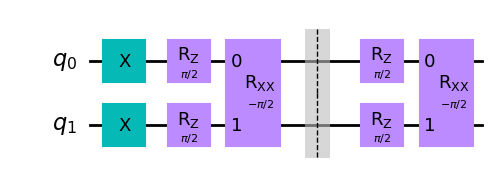

In [17]:
quantum_times = linspace(0, 2 * pi / frequency, 50)
shots = 1500
circuit = trotter_circuit(spins, pi, 2, frequency, coupling)
circuit.draw('mpl')

In [28]:
quantum_probabilities = zeros_like(quantum_times)
quantum_magnetization = zeros_like(quantum_times)
quantum_coupling_energy = zeros_like(quantum_times)

for i, t in enumerate(quantum_times):
    circuit = trotter_circuit(spins, t, 15, frequency, coupling)
    state_up = state_operator([0 for _ in range(spins)])
    quantum_probabilities[i] = measure_operator(state_up, circuit, shots)
    
    for j in range(spins):
        operator = quantum_operator_single_sz(spins, j)
        quantum_magnetization[i] += measure_operator(operator, circuit, shots)
        quantum_magnetization[i] += 1 / 2
        
    quantum_magnetization[i] /= spins  
     
    for pair in combinations(range(spins), 2):
        operator = quantum_operator_single_sxx(spins, *pair)
        quantum_coupling_energy[i] -= measure_operator(operator, circuit, shots)
        
    quantum_coupling_energy[i] *= 2 * coupling
    quantum_coupling_energy[i] /= spins * frequency

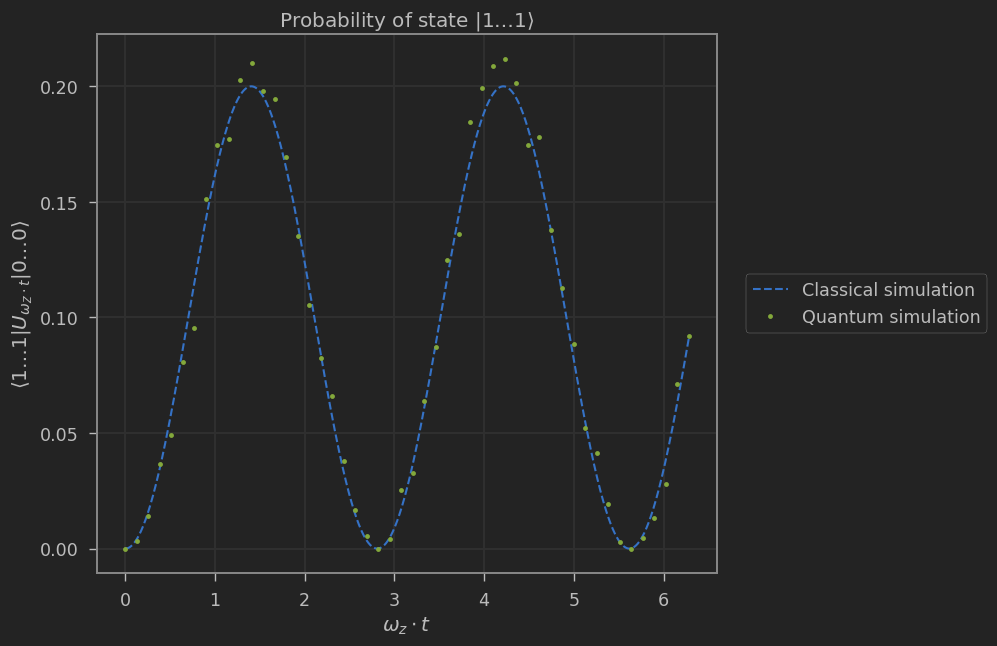

In [19]:
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, quantum_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

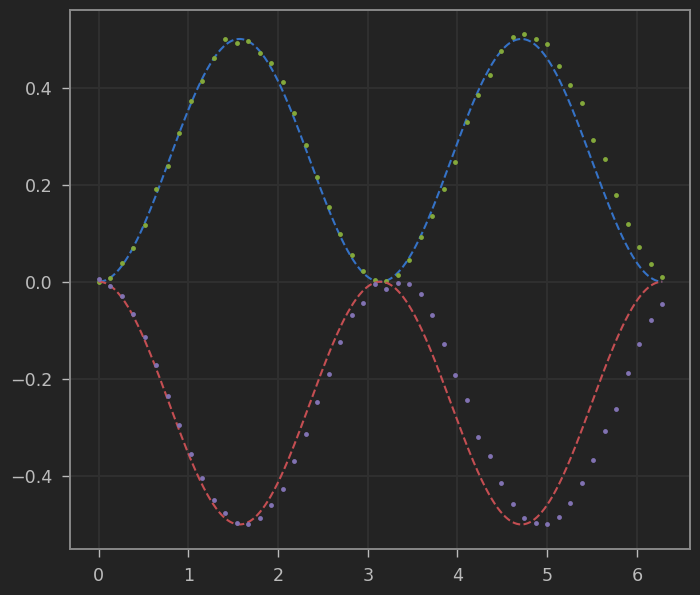

In [29]:
plot(times, magnetization, '--')
plot(quantum_times, quantum_magnetization, '.')
plot(times, coupling_energy, '--')
plot(quantum_times, quantum_coupling_energy, '.')
show()